### 7. Experiment Data Augmentation

In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.utils import class_weight
import numpy as np

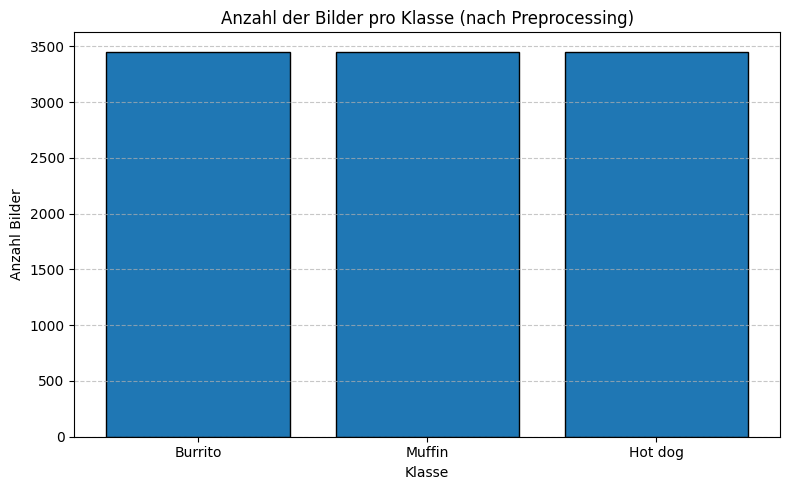

In [2]:
data_dir = "data_split/train_balanced"

# Bildanzahl pro Klasse
class_counts = {
    class_name: len([
        f for f in os.listdir(os.path.join(data_dir, class_name))
        if os.path.isfile(os.path.join(data_dir, class_name, f))
    ])
    for class_name in os.listdir(data_dir)
    if os.path.isdir(os.path.join(data_dir, class_name))
}

plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
plt.title("Anzahl der Bilder pro Klasse (nach Preprocessing)")
plt.xlabel("Klasse")
plt.ylabel("Anzahl Bilder")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Klassenverteilung nach dem Preprocessing

Die Visualisierung zeigt, dass ein deutliches Ungleichgewicht zwischen den Klassen besteht:

- Muffin ist überrepräsentiert
- Hot dog und Burrito sind unterrepräsentiert

Dieses Ungleichgewicht kann das Training verzerren und sollte durch Data Augmentation berücksichtigt werden.

In [3]:
def plot_augmentation(aug_layer, img_path, title):
    img = Image.open(img_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_batch = tf.expand_dims(img_array, 0)

    augmented = aug_layer(img_batch)
    aug_img = tf.clip_by_value(augmented[0], 0.0, 1.0).numpy()

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img_array)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(aug_img)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
example_image=f"{data_dir}/Burrito/000003.jpg"

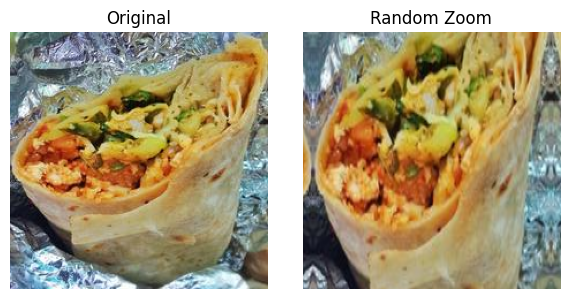

In [5]:
zoom_layer = tf.keras.layers.RandomZoom(height_factor=0.5, width_factor=0.2)
plot_augmentation(zoom_layer, example_image, "Random Zoom")

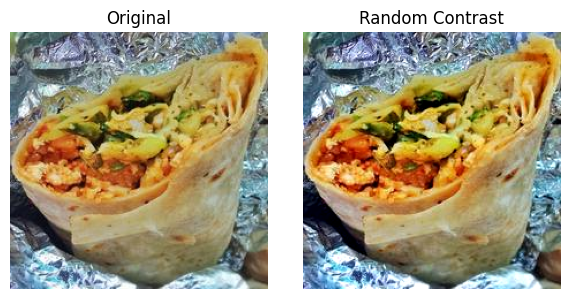

In [6]:
contrast_layer = tf.keras.layers.RandomContrast(factor=0.5)
plot_augmentation(contrast_layer, example_image, "Random Contrast")

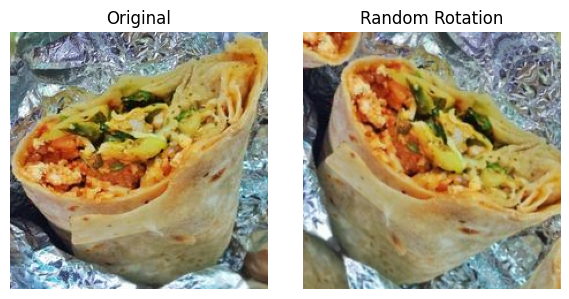

In [9]:
rotation_layer = tf.keras.layers.RandomRotation(factor=0.25)
plot_augmentation(rotation_layer, example_image, "Random Rotation")

### Load Training & Test Data

In [15]:
train_ds = image_dataset_from_directory(
    f"{data_dir}",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical",
    shuffle=True
)

val_ds = image_dataset_from_directory(
    f"data_split/test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="categorical"
)

Found 10362 files belonging to 3 classes.
Found 1861 files belonging to 3 classes.


In [18]:
# Extrahiere Labels aus dem train_ds
labels = []
for _, y in train_ds.unbatch():
    labels.append(np.argmax(y.numpy()))

# Berechne class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Konvertiere zu Dictionary (Keras erwartet das so)
class_weights = dict(enumerate(weights))

print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [18]:
def build_and_train_model(augmentation_layer, name, train_ds, val_ds):
    
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        pooling="avg"
    )
    
    base_model.trainable = True
    
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    model = tf.keras.Sequential([
        augmentation_layer,
        base_model,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        verbose=1,
        class_weight=class_weights
    )
    return history

def plot_histories(histories):
    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, history in histories.items():
        plt.plot(history.history['val_accuracy'], label=f"{name} (val)")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for name, history in histories.items():
        plt.plot(history.history['val_loss'], label=f"{name} (val)")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def evaluate_model(model, val_ds, class_names, name=""):
    y_true = []
    y_pred = []

    for x, y in val_ds.unbatch():
        true_class = np.argmax(y.numpy())
        pred_class = np.argmax(model.predict(tf.expand_dims(x, axis=0), verbose=0))
        y_true.append(true_class)
        y_pred.append(pred_class)

    # F1 Score (macro für unbalanced)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} – Macro F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix: {name}")
    plt.grid(False)
    plt.show()

### Define Pipelines

In [19]:
rescale = tf.keras.layers.Rescaling(1./255)

zoom_aug = tf.keras.Sequential([
    tf.keras.layers.RandomZoom(0.3),
    rescale
])

contrast_aug = tf.keras.Sequential([
    tf.keras.layers.RandomContrast(0.5),
    rescale
])

rotation_aug = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.25),
    rescale
])

In [20]:
histories = {}
histories["zoom"] = build_and_train_model(zoom_aug, "zoom", train_ds, val_ds)
histories["contrast"] = build_and_train_model(contrast_aug, "contrast", train_ds, val_ds)
histories["rotation"] = build_and_train_model(rotation_aug, "rotation", train_ds, val_ds)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.7993 - loss: 1.1024 - val_accuracy: 0.8608 - val_loss: 0.5697
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.8635 - loss: 0.8872 - val_accuracy: 0.8608 - val_loss: 0.5282
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 240s 2s/step - accuracy: 0.8632 - loss: 0.8572 - val_accuracy: 0.8608 - val_loss: 2.3309
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - accuracy: 0.8591 - loss: 0.8687 - val_accuracy: 0.8608 - val_loss: 2.2613
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8609 - loss: 0.8085 - val_accuracy: 0.8608 - val_loss: 0.5360
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 244s 2s/step - accuracy: 0.8630 - loss: 0.7719 - val_accuracy: 0.8608 - val_loss: 3.0774
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.8622 - loss: 0.8107 - val_accuracy: 0.8630 - val_loss: 0.8195
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.8613 - loss: 0.7637 - val_accu

KeyboardInterrupt: 

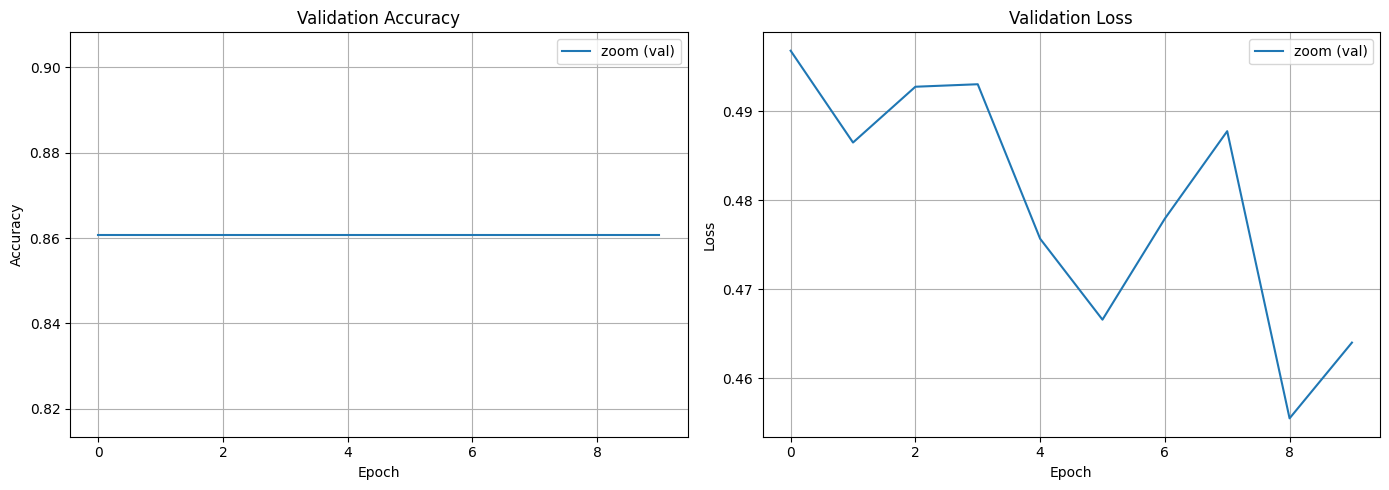

In [76]:
plot_histories(histories)